# Brief about the Data set and Goal
Goal: To build and train an DL model that can detect brain tumour and also classify it

Medical Image Dataset: Brain Tumor Detection
The Brain Tumor MRI dataset, curated by Roboflow Universe, is a comprehensive dataset designed for the detection and classification of brain tumors using advanced computer vision techniques. It comprises 3,903 MRI images categorized into four distinct classes:

Glioma: A tumor originating from glial cells in the brain.
Meningioma: Tumors arising from the meninges, the protective layers surrounding the brain and spinal cord.
Pituitary Tumor: Tumors located in the pituitary gland, affecting hormonal balance.
No Tumor: MRI scans that do not exhibit any tumor presence.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#importing the dataset and files
!unzip "/content/drive/MyDrive/archive.zip" -d "/content/archive"

Streaming output truncated to the last 5000 lines.
  inflating: /content/archive/BrainTumor/BrainTumorYolov9/train/images/1654_jpg.rf.4fe2965cdae5a7b6140f687ff07f8747.jpg  
  inflating: /content/archive/BrainTumor/BrainTumorYolov9/train/images/1655_jpg.rf.393b93140d1977b2e8aa2f8ac54e8444.jpg  
  inflating: /content/archive/BrainTumor/BrainTumorYolov9/train/images/1656_jpg.rf.acb5b0befa0cc43b3e496de8bce6a76d.jpg  
  inflating: /content/archive/BrainTumor/BrainTumorYolov9/train/images/1657_jpg.rf.f3c798e75c0eb3258a63df6d2ad83e10.jpg  
  inflating: /content/archive/BrainTumor/BrainTumorYolov9/train/images/1658_jpg.rf.a8e88eff5b73bac7ca4269df851fb807.jpg  
  inflating: /content/archive/BrainTumor/BrainTumorYolov9/train/images/1659_jpg.rf.38ff712e48863df32444e55465bb20c9.jpg  
  inflating: /content/archive/BrainTumor/BrainTumorYolov9/train/images/165_jpg.rf.9933a9ac7f8a797bf07cb89b6c97b19a.jpg  
  inflating: /content/archive/BrainTumor/BrainTumorYolov9/train/images/1662_jpg.rf.57fb3a6beb506

#Checking Data paths

In [3]:
import os
os.listdir("/content/archive/BrainTumor/BrainTumorYolov8")

['valid', 'test', 'data.yaml', 'train']

In [4]:
os.listdir("/content/archive/BrainTumor/BrainTumorYolov8/test")

['images', 'labels']

# Data Anlysis

In [5]:
def count_images(path):
  return len ([f for f in os.listdir(path) if  f.endswith((".jpg", ".png", ".jpeg"))])

train_images = count_images("/content/archive/BrainTumor/BrainTumorYolov8/train/images")
valid_images = count_images("/content/archive/BrainTumor/BrainTumorYolov8/valid/images")
test_images = count_images("/content/archive/BrainTumor/BrainTumorYolov8/test/images")

print("Train images:", train_images)
print("Validation images:", valid_images)
print("Test images:", test_images)


Train images: 2144
Validation images: 612
Test images: 308


In [6]:
#counting Labels per class
from collections import Counter

label_path = "/content/archive/BrainTumor/BrainTumorYolov8/train/labels"
class_counter = Counter()

for label_file in os.listdir(label_path):
    if label_file.endswith(".txt"):
        with open(os.path.join(label_path, label_file)) as f:
            for line in f:
                class_id = int(line.split()[0])
                class_counter[class_id] += 1

print("Class distribution (TRAIN):")
for class_id, count in class_counter.items():
    print(f"Class {class_id}: {count}")


Class distribution (TRAIN):
Class 1: 503
Class 0: 983
Class 2: 658


In [7]:
with open("/content/archive/BrainTumor/BrainTumorYolov8/data.yaml", "r") as f:
    print(f.read())

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['glioma', 'meningioma', 'pituitary']




In [8]:
import pandas as pd
class_count= {
    0: ("Glioma", 983),
    1: ("meningioma", 503),
    2: ("pituitary", 658)
}
##########
total = sum(count for _, count in class_count.values())

counter= []

for cls,  (label, count) in class_count.items():
    percent = (count / total) * 100
    counter.append([cls, label, count, f"{percent:.2f}%"])

df = pd.DataFrame(counter, columns=["Class", "Label", "Count", "Approx %"])
df



,Class,Label,Count,Approx %
0,0,Glioma,983,45.85%
1,1,meningioma,503,23.46%
2,2,pituitary,658,30.69%


#Annotation veriifcation and checking visual image and there Labelling

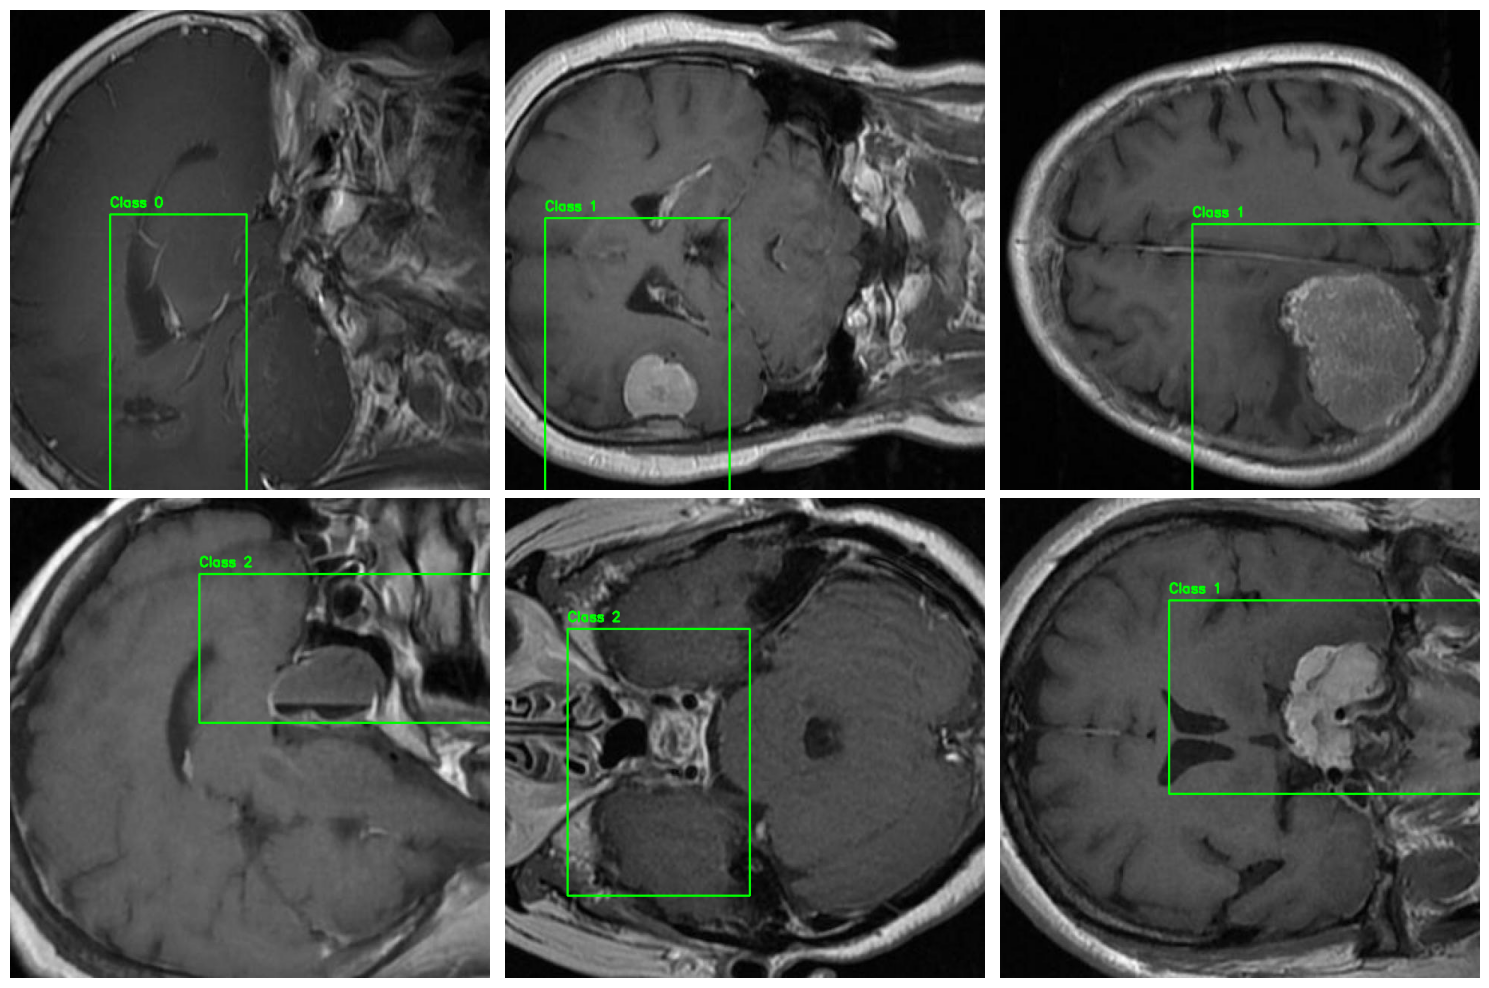

In [9]:
import cv2
import random
import matplotlib.pyplot as plt

image_dir = "/content/archive/BrainTumor/BrainTumorYolov8/train/images"
label_dir = "/content/archive/BrainTumor/BrainTumorYolov8/train/labels"

sample_images = random.sample(os.listdir(image_dir), 6)

plt.figure(figsize=(15, 10))

for i, img_file in enumerate(sample_images):
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, img_file.rsplit(".", 1)[0] + ".txt")

    img = cv2.imread(img_path)
    h, w, _ = img.shape

    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                parts = line.split()
                cls = int(parts[0])
                x, y, bw, bh = map(float, parts[1:5])

                x1 = int((x - bw/2) * w)
                y1 = int((y - bh/2) * h)
                x2 = int((x + bw/2) * w)
                y2 = int((y + bh/2) * h)

                cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
                cv2.putText(img, f"Class {cls}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    plt.subplot(2, 3, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.tight_layout()
plt.show()

#Installing YOLO v8

In [10]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.8 MB/s eta 0:00:00


In [11]:
from ultralytics import YOLO
print("YOLOv8 is ready")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
YOLOv8 is ready


In [12]:
####Training mode

#loading yolovb nano model
model = YOLO("yolov8n.pt")

#Training
model.train(
    data = "/content/archive/BrainTumor/BrainTumorYolov8/data.yaml",
    epochs= 50,
    imgsz= 640,
    batch= 16,
    device= 0
)

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/archive/BrainTumor/BrainTumorYolov8/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78da0be333e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

#Testing the Model

In [13]:
model = YOLO("/content/runs/detect/train/weights/best.pt")

model.predict(
    source="/content/archive/BrainTumor/BrainTumorYolov8/test/images",
    conf=0.25,
    save=True
)


image 1/308 /content/archive/BrainTumor/BrainTumorYolov8/test/images/1003_jpg.rf.028d6d76fba92dd9e5dc59dc9d0f7293.jpg: 640x640 1 pituitary, 7.0ms
image 2/308 /content/archive/BrainTumor/BrainTumorYolov8/test/images/1012_jpg.rf.a9d8d27f5e1d382e0b93ff4a479f4519.jpg: 640x640 1 pituitary, 14.0ms
image 3/308 /content/archive/BrainTumor/BrainTumorYolov8/test/images/1018_jpg.rf.29ed2fb6754ca58ae27204ef24344650.jpg: 640x640 1 pituitary, 10.9ms
image 4/308 /content/archive/BrainTumor/BrainTumorYolov8/test/images/102_jpg.rf.e58e0fc30dfea3a7a410d7b901223f16.jpg: 640x640 1 meningioma, 9.1ms
image 5/308 /content/archive/BrainTumor/BrainTumorYolov8/test/images/1033_jpg.rf.1b4c0f5bdf30ec0ba218874a3a737720.jpg: 640x640 1 pituitary, 7.6ms
image 6/308 /content/archive/BrainTumor/BrainTumorYolov8/test/images/1037_jpg.rf.7c415f051556bbba83bc00f70fe54818.jpg: 640x640 1 pituitary, 12.1ms
image 7/308 /content/archive/BrainTumor/BrainTumorYolov8/test/images/1041_jpg.rf.252e75e8f025b79f801db895122613d3.jpg: 6

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'glioma', 1: 'meningioma', 2: 'pituitary'}
 obb: None
 orig_img: array([[[4, 4, 4],
         [4, 4, 4],
         [4, 4, 4],
         ...,
         [3, 3, 3],
         [3, 3, 3],
         [3, 3, 3]],
 
        [[4, 4, 4],
         [4, 4, 4],
         [4, 4, 4],
         ...,
         [3, 3, 3],
         [3, 3, 3],
         [3, 3, 3]],
 
        [[4, 4, 4],
         [4, 4, 4],
         [4, 4, 4],
         ...,
         [3, 3, 3],
         [3, 3, 3],
         [3, 3, 3]],
 
        ...,
 
        [[4, 4, 4],
         [4, 4, 4],
         [4, 4, 4],
         ...,
         [4, 4, 4],
         [4, 4, 4],
         [4, 4, 4]],
 
        [[4, 4, 4],
         [4, 4, 4],
         [4, 4, 4],
         ...,
         [4, 4, 4],
         [4, 4, 4],
         [4, 4, 4]],
 
        [[4, 4, 4],
         [4, 4, 4],
         [4, 4, 4],
         ...,
         [

In [14]:
pred_dir = "/content/runs/detect/predict"
images = os.listdir(pred_dir)

plt.figure(figsize=(15, 10))

for i, img_file in enumerate(images[:6]):  # show first 6
    img = cv2.imread(os.path.join(pred_dir, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis("off")

plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

#Model Evaluation

In [15]:
model.val(
    data="/content/archive/BrainTumor/BrainTumorYolov8/data.yaml"
)

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 695.3±360.6 MB/s, size: 33.3 KB)
val: Scanning /content/archive/BrainTumor/BrainTumorYolov8/valid/labels.cache... 612 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 612/612 213.9Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 39/39 6.1it/s 6.4s
                   all        612        612      0.862      0.885      0.916      0.717
                glioma        285        285      0.755      0.772      0.814      0.563
            meningioma        142        142      0.944      0.944      0.976      0.836
             pituitary        185        185      0.887      0.941      0.959      0.753
Speed: 1.4ms preprocess, 4.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /content/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78db410e4800>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04